In [1]:
### 1. Импорты и загрузка конфигурации
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import yaml
from dataclasses import dataclass, field
import logging

# --- Настройка импортов ---
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '')))

from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.tree_evaluator import TreeEvaluator
from src.losses.universal_pairing_loss import universal_loss, UniversalLossConfig
from src.matching.soft_assignment import SinkhornConfig, sinkhorn, pairwise_sqdist
from src.visualize_spore_tree import visualize_spore_tree

# --- Загрузка конфигурации ---
try:
    with open('config/optimization.yaml', 'r', encoding='utf-8') as f:
        config_yaml = yaml.safe_load(f)
except FileNotFoundError:
    print("Ошибка: Файл 'config/optimization.yaml' не найден.")
    config_yaml = None

if config_yaml:
    opt_config = config_yaml['optimizer']
    sk_config = SinkhornConfig(
        eps=config_yaml['sinkhorn']['eps_init'],
        n_iter=config_yaml['sinkhorn']['n_iter'],
        annea_schedule=tuple(config_yaml['sinkhorn']['annea_schedule'])
    )
    loss_config = UniversalLossConfig(
        margin=config_yaml['loss']['margin'],
        lam_push=config_yaml['loss']['lam_push'],
        forbid_self=config_yaml['loss']['forbid_self']
    )
    integ_config = config_yaml['integration']
    print("✅ Конфигурация успешно загружена.")


✅ Конфигурация успешно загружена.


In [2]:
### 2. Настройка логирования
LOG_FILE = 'optimization_debug.log'
# Очищаем файл лога перед новым запуском
if os.path.exists(LOG_FILE):
    os.remove(LOG_FILE)

# Удаляем существующие обработчики, чтобы избежать дублирования
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(LOG_FILE, encoding='utf-8'), # Явно указываем кодировку
        logging.StreamHandler(sys.stdout) 
    ]
)

logging.info("Логгер инициализирован.")


2025-08-12 23:27:27,826 - INFO - Логгер инициализирован.


In [3]:
### 3. Инициализация системы
pendulum = PendulumSystem()
spore_tree_config = SporeTreeConfig(
    initial_position=np.array([np.pi/2, 0.0]),
    dt_base=integ_config['step_size'],
    dt_grandchildren_factor=0.1,
    show_debug=False
)

tree = SporeTree(pendulum, spore_tree_config)
evaluator = TreeEvaluator(tree)

num_children = 4
num_grandchildren_per_child = 2
num_total_grandchildren = num_children * num_grandchildren_per_child
num_params = num_children + num_total_grandchildren

logging.info(f"Система инициализирована. Количество параметров: {num_params}")


2025-08-12 23:27:27,847 - INFO - Система инициализирована. Количество параметров: 12


In [4]:
### 4. Функции для цикла оптимизации с логированием

@dataclass
class OptimizationState:
    iteration: int = 0
    history: list = field(default_factory=list)

# !!! Cоздаем opt_state здесь, чтобы он не сбрасывался при перезапуске ячеек !!!
opt_state = OptimizationState()
# Загружаем веса для новой функции потерь
loss_weights = config_yaml.get('loss_weights', {})


def objective_for_minimize(dt_all, state):
    # Используем dynamic_loss из TreeEvaluator
    total_loss = evaluator.dynamic_loss(dt_all, **loss_weights)
    return total_loss

def callback_function(current_dt):
    # Обновляем историю в коллбэке
    loss_components = evaluator.calculate_loss_components(current_dt, alpha=loss_weights.get('alpha', 10.0))
    total_loss = (
        loss_weights.get('w_distance', 1.0) * loss_components['distance_loss'] +
        loss_weights.get('w_velocity', 0.0) * loss_components['velocity_loss'] +
        loss_weights.get('w_repulsion', 0.0) * loss_components['repulsion_loss']
    )
    
    logging.info(f"Iter {opt_state.iteration}: Dist={loss_components['distance_loss']:.4f}, Vel={loss_components['velocity_loss']:.4f}, Repulsion={loss_components['repulsion_loss']:.4f}, Total={total_loss:.4f}")
    
    opt_state.history.append({
        'iteration': opt_state.iteration,
        'total_loss': total_loss,
        'distance_loss': loss_components['distance_loss'],
        'velocity_loss': loss_components['velocity_loss'],
        'repulsion_loss': loss_components['repulsion_loss'],
    })

    opt_state.iteration += 1

logging.info("Функции для оптимизации определены.")

2025-08-12 23:27:27,865 - INFO - Функции для оптимизации определены.


In [5]:
### 5. Запуск оптимизации

# Сбрасываем состояние перед новым запуском
opt_state = OptimizationState()
evaluator = TreeEvaluator(tree)

initial_dt = spore_tree_config.get_default_dt_vector()

# Добавляем БОЛЬШИЙ шум для нарушения симметрии
np.random.seed(42) # для воспроизводимости
initial_dt += np.random.uniform(-0.005, 0.005, size=initial_dt.shape)


bounds = [(0.001, 0.2)] * num_params

# Обертка теперь проще
objective_wrapped = lambda dt: objective_for_minimize(dt, opt_state)

logging.info("--- НАЧАЛО ОПТИМИЗАЦИИ ---")
logging.info(f"Начальные dt (с шумом): {np.round(initial_dt, 6)}")

# Сохраняем начальное состояние дерева для визуализации
evaluator._build_if_needed(initial_dt)
initial_tree_state = {
    'root': tree.root.copy(),
    'children': [c.copy() for c in tree.children],
    'grandchildren': [gc.copy() for gc in tree.grandchildren]
}


result = minimize(
    objective_wrapped, 
    initial_dt, 
    method=opt_config['method'],
    bounds=bounds, 
    callback=callback_function,
    options={
        'maxiter': opt_config['max_iters'], 
        'disp': True, 
        'ftol': float(opt_config['tol']),
        'eps': 1e-8
    }
)
logging.info("--- ОПТИМИЗАЦИЯ ЗАВЕРШЕНА ---")
logging.info(f"Сообщение: {result.message}")
logging.info(f"Финальные dt: {np.round(result.x, 6)}")


2025-08-12 23:27:27,877 - INFO - --- НАЧАЛО ОПТИМИЗАЦИИ ---
2025-08-12 23:27:27,879 - INFO - Начальные dt (с шумом): [0.098745 0.104507 0.10232  0.100987 0.00656  0.00656  0.005581 0.013662
 0.011011 0.012081 0.005206 0.014699]
2025-08-12 23:27:27,889 - INFO - Iter 0: Dist=-0.1690, Vel=-5.5266, Repulsion=25.8615, Total=0.5714
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5714281587047282
            Iterations: 1
            Function evaluations: 13
            Gradient evaluations: 1
2025-08-12 23:27:27,891 - INFO - --- ОПТИМИЗАЦИЯ ЗАВЕРШЕНА ---
2025-08-12 23:27:27,892 - INFO - Сообщение: Optimization terminated successfully
2025-08-12 23:27:27,893 - INFO - Финальные dt: [0.098745 0.104507 0.10232  0.100987 0.00656  0.00656  0.005581 0.013662
 0.011011 0.012081 0.005206 0.014699]


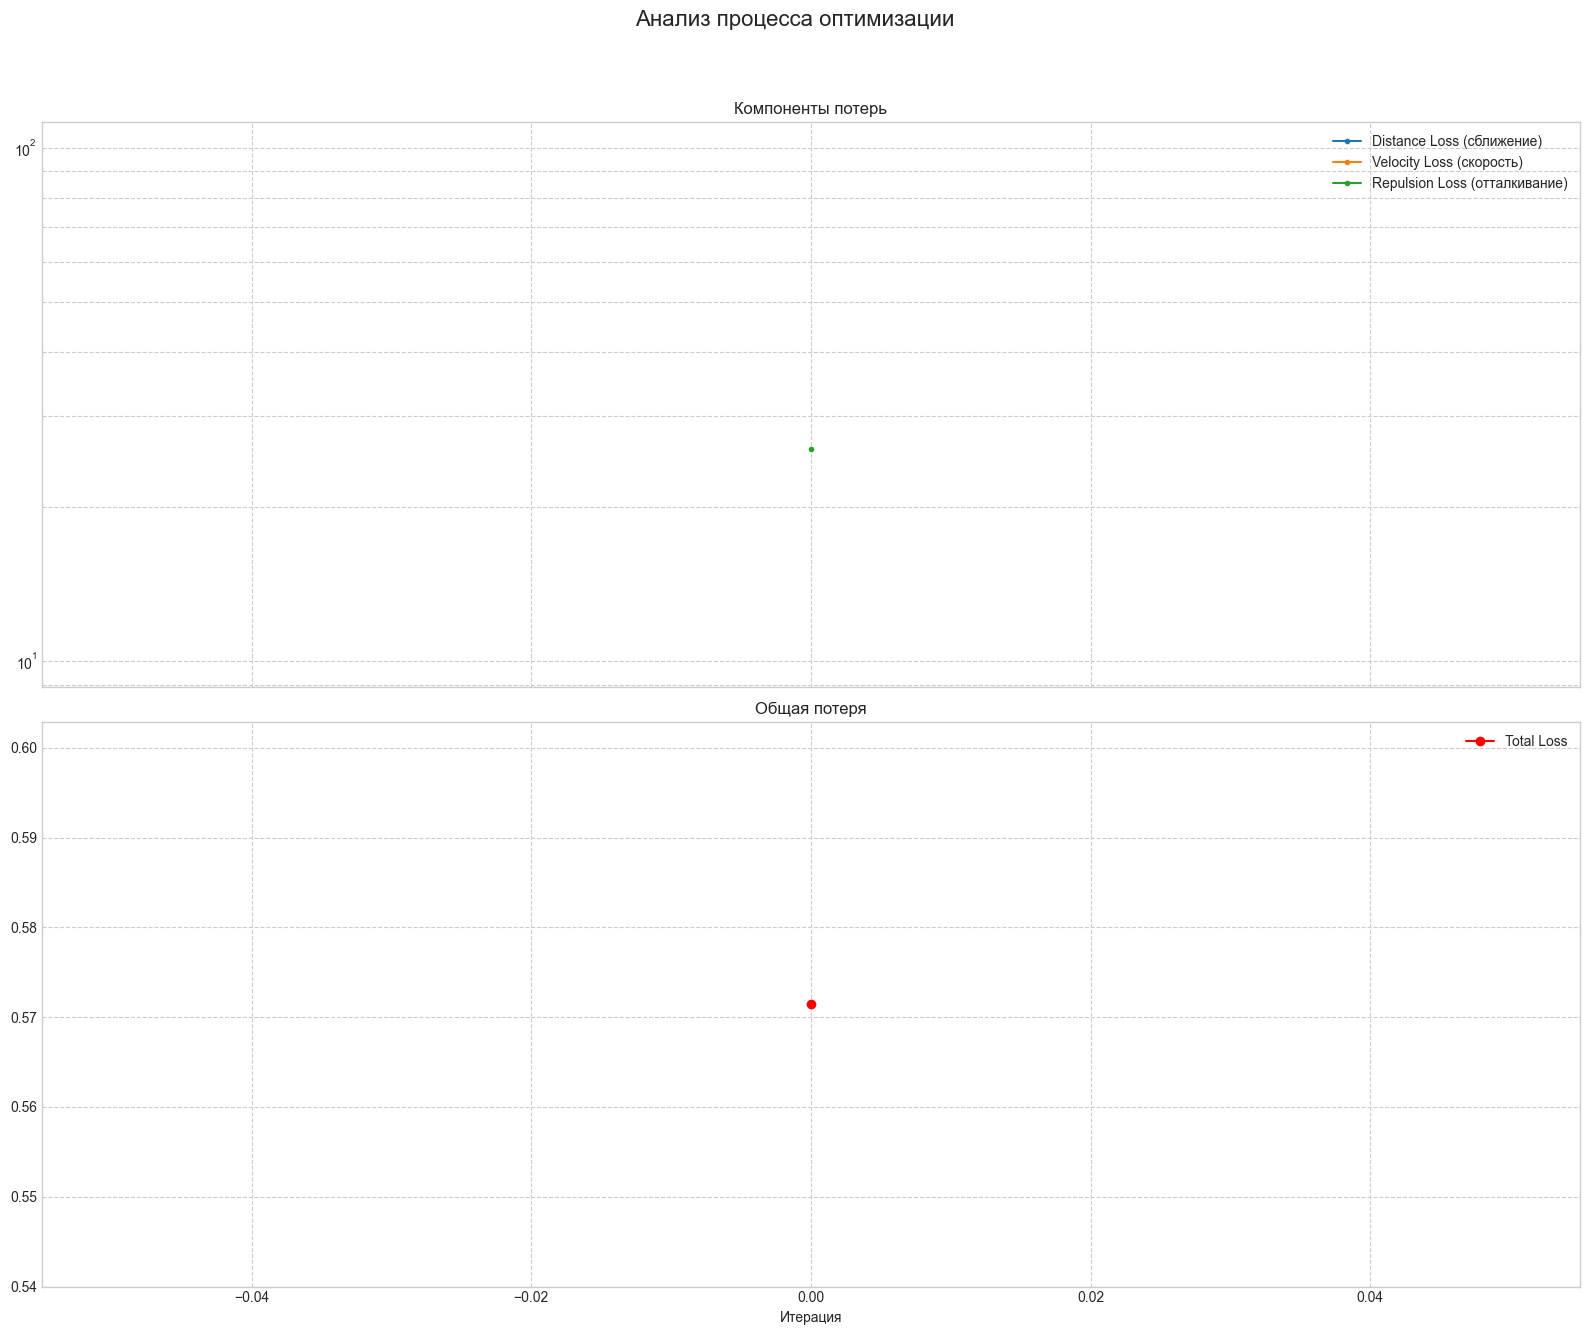

In [6]:
### 6. Анализ и визуализация истории потерь

history_df = pd.DataFrame(opt_state.history)

if history_df.empty:
    logging.warning("История пуста. Графики не будут построены.")
else:
    plt.style.use('seaborn-v0_8-whitegrid')
    # Создаем 2 графика: один для компонентов, другой для общей потери
    fig, ax = plt.subplots(2, 1, figsize=(16, 14), sharex=True)
    fig.suptitle('Анализ процесса оптимизации', fontsize=16)

    # --- График 1: Компоненты потерь ---
    ax[0].plot(history_df['iteration'], history_df['distance_loss'], marker='.', label='Distance Loss (сближение)')
    ax[0].plot(history_df['iteration'], history_df['velocity_loss'], marker='.', label='Velocity Loss (скорость)')
    ax[0].plot(history_df['iteration'], history_df['repulsion_loss'], marker='.', label='Repulsion Loss (отталкивание)')
    ax[0].set_title('Компоненты потерь')
    ax[0].legend()
    ax[0].set_yscale('log') # Логарифмическая шкала может быть полезной
    ax[0].grid(True, which="both", ls="--")


    # --- График 2: Общая потеря ---
    ax[1].plot(history_df['iteration'], history_df['total_loss'], marker='o', color='r', label='Total Loss')
    ax[1].set_title('Общая потеря')
    ax[1].set_xlabel('Итерация')
    ax[1].legend()
    ax[1].grid(True, which="both", ls="--")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


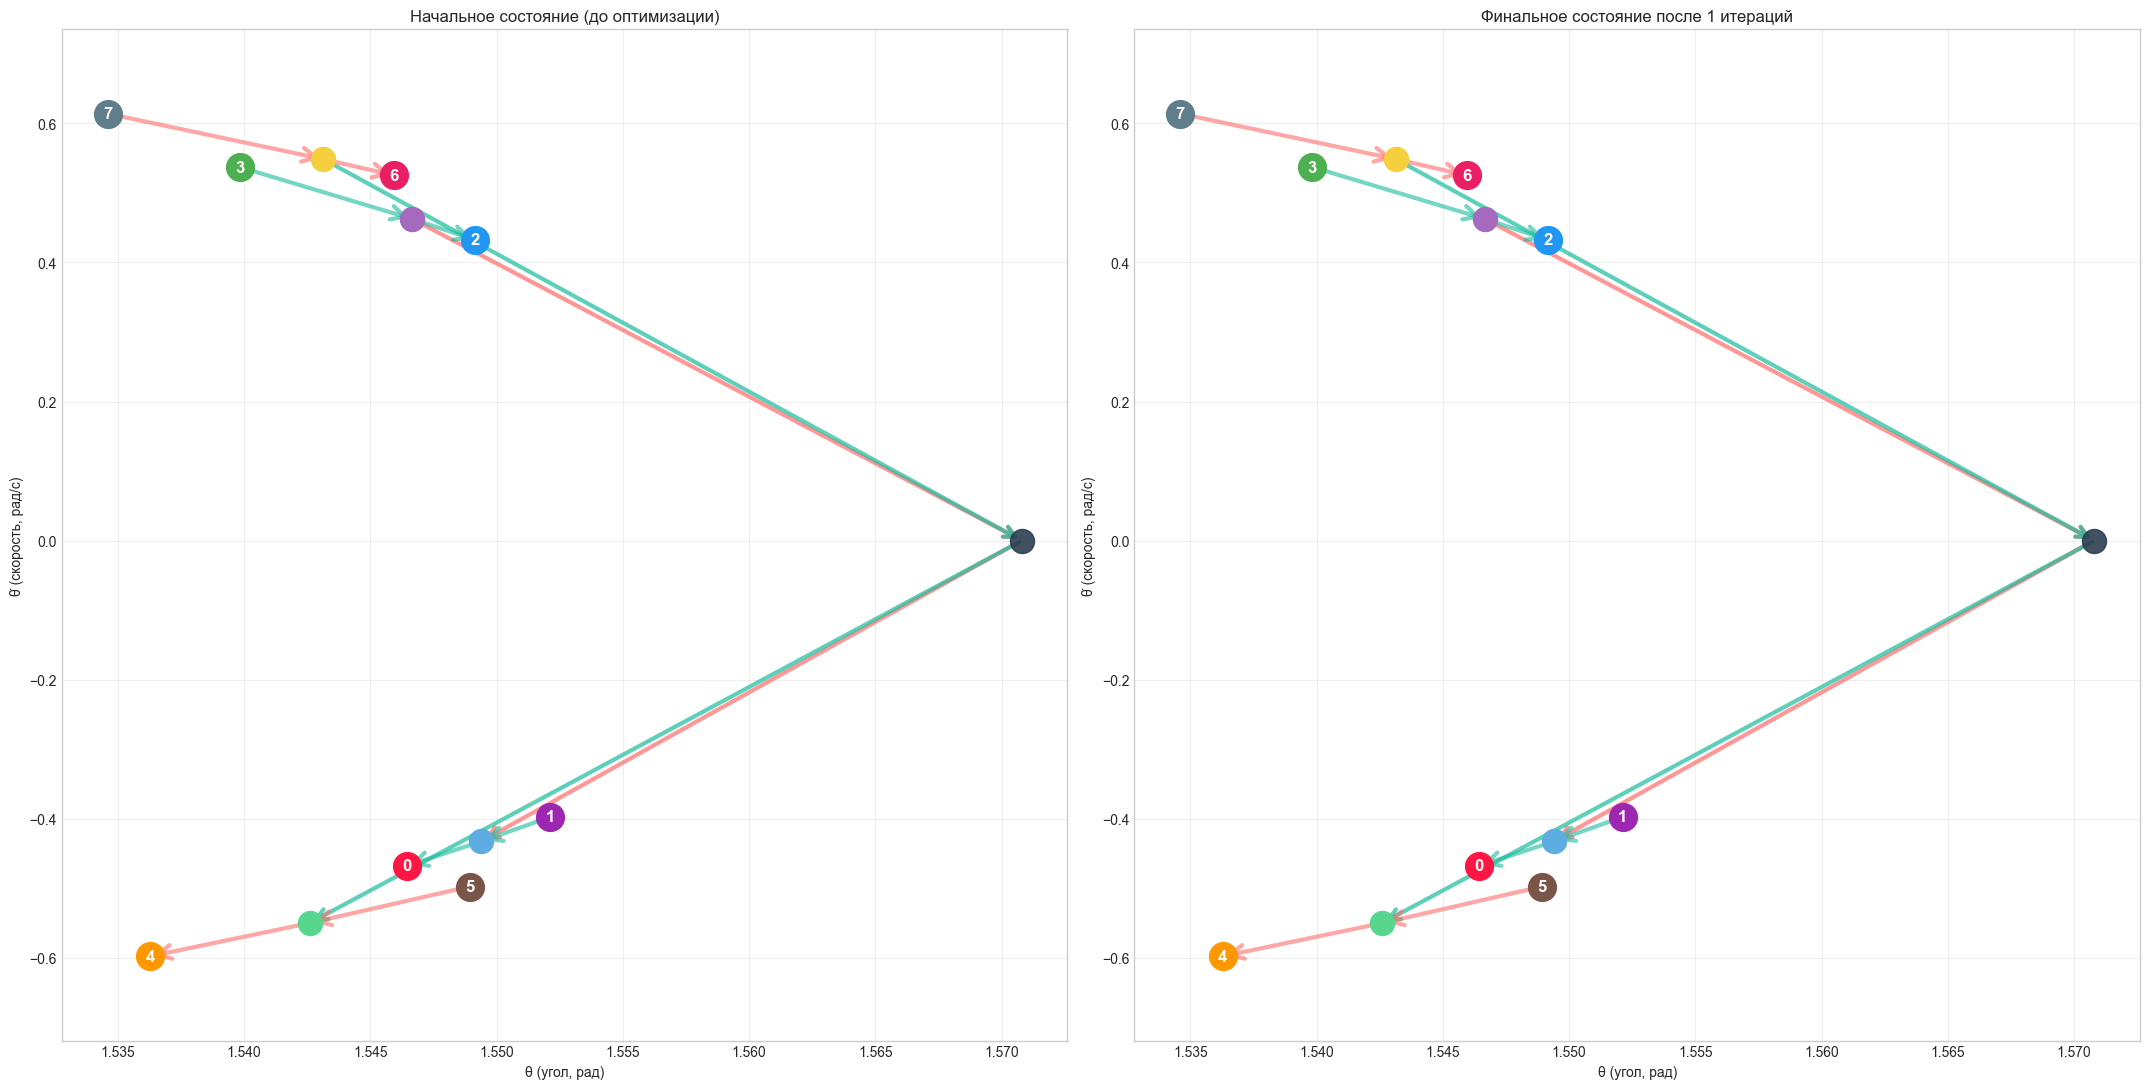

In [7]:
### 7. Сравнительная визуализация "до" и "после"

if 'result' in locals() and result.success and 'initial_tree_state' in locals():
    # Создаем фигуру с двумя графиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 11))
    
    # --- График 1: Начальное состояние ---
    visualize_spore_tree(
        initial_tree_state, 
        title="Начальное состояние (до оптимизации)",
        ax=ax1,
        show_legend=False
    )
    
    # --- График 2: Финальное состояние ---
    # Пересчитываем дерево с финальными dt
    evaluator._build_if_needed(result.x)
    visualize_spore_tree(
        tree, 
        title=f"Финальное состояние после {result.nit} итераций",
        ax=ax2,
        show_legend=True
    )
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    # plt.axis
    plt.show()
    
else:
    logging.warning("Оптимизация не была успешно завершена или начальное состояние не сохранено. "
                    "Финальная визуализация пропущена.")


In [ ]:
### 8. Анализ финальной матрицы соответствия (P)

if 'result' in locals() and result.success:
    # Пересчитываем дерево с финальными dt
    evaluator._build_if_needed(result.x)
    X_final = np.array([gc['position'] for gc in tree.grandchildren])
    
    # Получаем финальную eps, которая была на последней итерации
    final_iter = opt_state.iteration - 1 if opt_state.iteration > 0 else 0
    current_eps_idx = np.searchsorted(annealing_steps, final_iter, side='right') - 1
    final_eps = sk_config.annea_schedule[current_eps_idx]

    sk_cfg_final = SinkhornConfig(eps=final_eps, n_iter=sk_config.n_iter)
    
    # Вычисляем финальные потери и матрицу P
    final_loss_dict = universal_loss(
        X_final, loss_config, sk_cfg_final,
        pairing_map=tree.pairing_candidate_map
    )
    P_final = final_loss_dict['P']
    
    # --- Визуализация в ноутбуке ---
    P_df = pd.DataFrame(P_final)
    styled_df = P_df.style.background_gradient(cmap='viridis', axis=None)\
                            .format("{:.3f}")\
                            .set_caption("Матрица мягкого соответствия P (финальная)")\
                            .set_properties(**{'width': '80px'})
    
    print("--- Матрица соответствия P (визуализация для ноутбука) ---")
    display(styled_df)
    
    # --- Вывод в лог ---
    logging.info("--- Матрица соответствия P (финальная) ---")
    logging.info("\n" + P_df.to_string(float_format="{:.4f}".format))
    
    # --- Дополнительная информация ---
    best_pairs_info = "\nСамая вероятная пара для каждого внука:\n"
    for i in range(len(P_final)):
        best_match_idx = np.argmax(P_final[i])
        confidence = P_final[i, best_match_idx]
        best_pairs_info += f"  Внук {i} -> Внук {best_match_idx} (уверенность: {confidence:.3f})\n"

    print(best_pairs_info)
    logging.info(best_pairs_info)

else:
    logging.warning("Оптимизация не была успешно завершена. Анализ матрицы P пропущен.")

NameError: name 'annealing_steps' is not defined

: 